In [13]:
import ugradio
import ugradio.coord
import astropy.coordinates
import astropy.time
import time
import numpy as np
import matplotlib.pylab as plt
import inspect
import collections
from scipy.interpolate import interp1d
# import emcee

In [14]:
pwd = '/home/zoeko/astro121lab/lab3/data/sun/'
pwd = '/home/pi/Blueberry Pi/astro121lab/lab3/data/sun/'

def freq_to_period(freq):
    '''take frequency (in kHz)
    and converts to period (in microseconds)'''
    return (1/freq) * 1000

freq = 500 * 1000 * 1000 # Hz

In [15]:
fname = f'{pwd}full_day_sun_pt2.npy'
data = np.load(fname, allow_pickle=True)

In [16]:
total_duration = (data[-1]['time']-data[0]['time'])/60
print(total_duration)

10.757647303740184


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  re

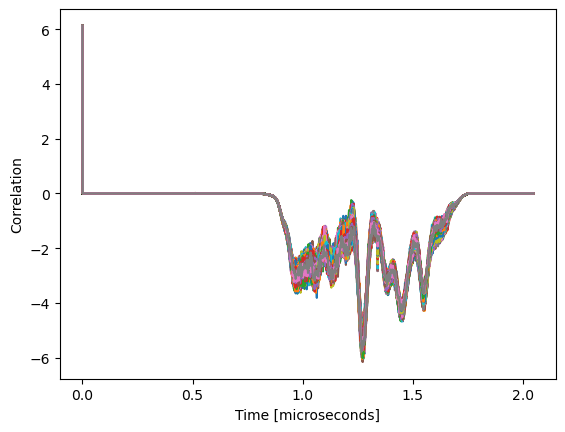

In [17]:
for i in range(len(data)):
    data_block = data[i]
    corr = data_block['corr01']
    data_time = data_block['time']
    time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds
    plt.plot(time, corr)
    plt.xlabel('Time [microseconds]')
    plt.ylabel('Correlation')
plt.show()

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


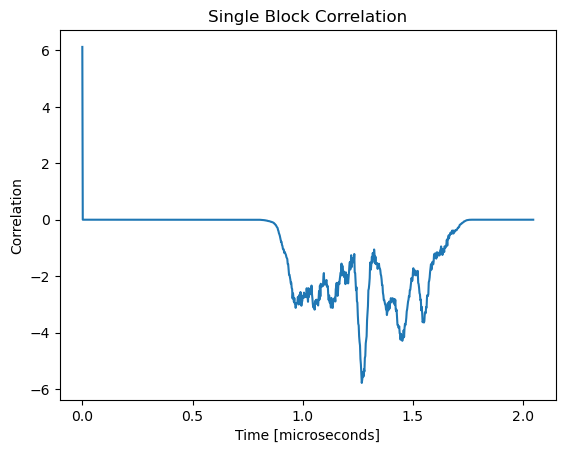

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


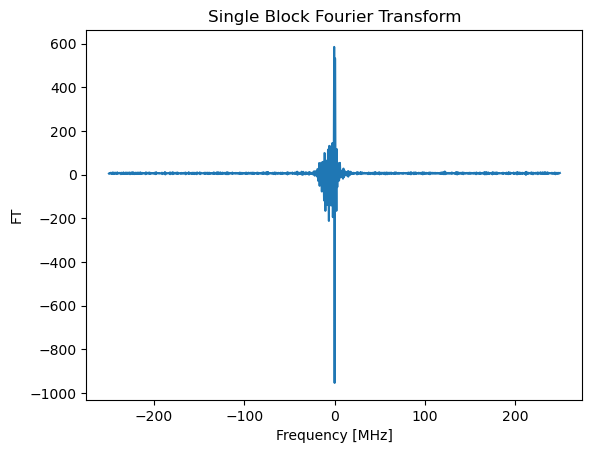

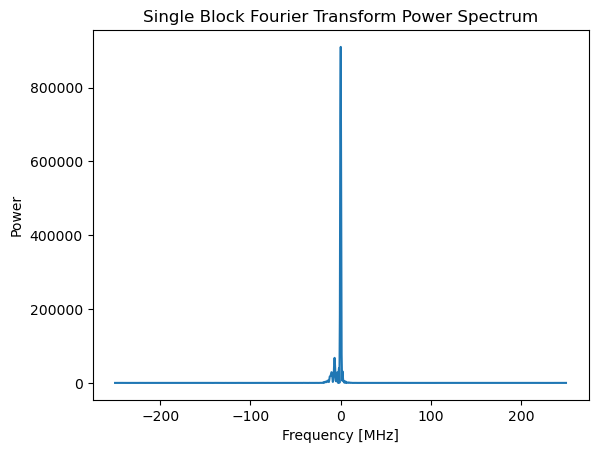

In [18]:
# plot one block of data (waveform)
plt.figure()
plt.plot(time, corr)
plt.title('Single Block Correlation')
plt.xlabel('Time [microseconds]')
plt.ylabel('Correlation')
plt.show()

f = np.fft.fftshift(np.fft.fftfreq(1024, 1/freq))
Fx = np.fft.fftshift(np.fft.fft(corr))
pwr = np.abs(Fx)**2

# plot one block of data (FT)
plt.figure()
plt.plot(f/10**6, Fx)
plt.title('Single Block Fourier Transform')
plt.xlabel('Frequency [MHz]')
plt.ylabel('FT')
plt.show()

# plot one block of data (power)
plt.figure()
plt.plot(f/10**6, pwr)
plt.title('Single Block Fourier Transform Power Spectrum')
plt.xlabel('Frequency [MHz]')
plt.ylabel('Power')
plt.show()

In [57]:
all_cor = []
for i in np.arange(len(data)):
    data_block = data[i]
    data_block_corr = data_block['corr01'].real
    all_cor += [data_block_corr]

<IPython.core.display.Javascript object>


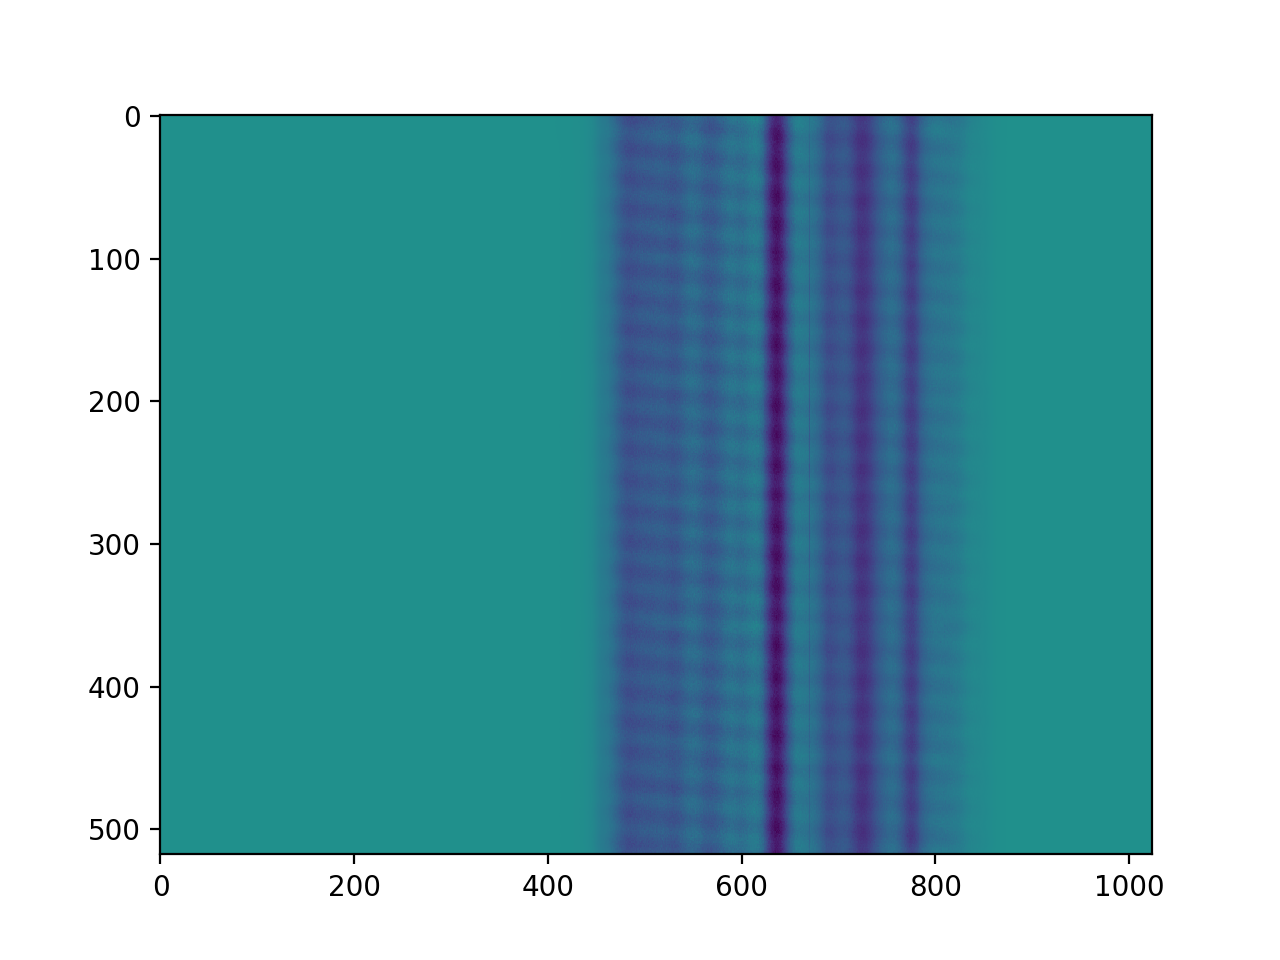

In [58]:
# %matplotlib notebook
plt.figure()
plt.imshow(all_cor, aspect='auto', interpolation='nearest')
plt.show()

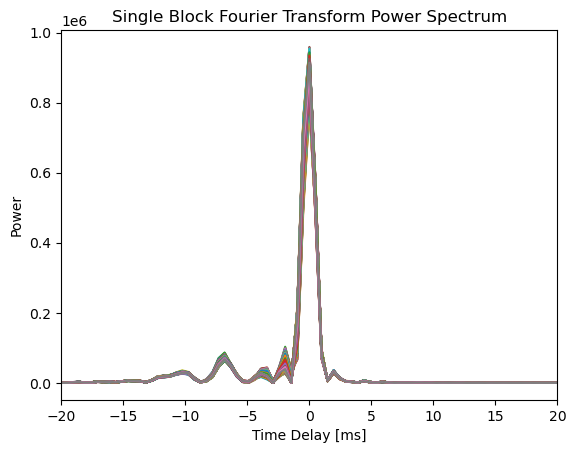

In [19]:
# %matplotlib notebook
for i in range(len(data)):
    data_block = data[i]
    corr = data_block['corr01']
    data_time = data_block['time']
    time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds

    f = np.fft.fftshift(np.fft.fftfreq(1024, 1/freq))
    Fx = np.fft.fftshift(np.fft.fft(corr))
    pwr = np.abs(Fx)**2

    # plot one block of data (power)
    plt.plot(f/10**6, pwr)

plt.title('Single Block Fourier Transform Power Spectrum')
plt.xlabel('Time Delay [ms]')
plt.ylabel('Power')
plt.xlim(-20, 20)
plt.show()

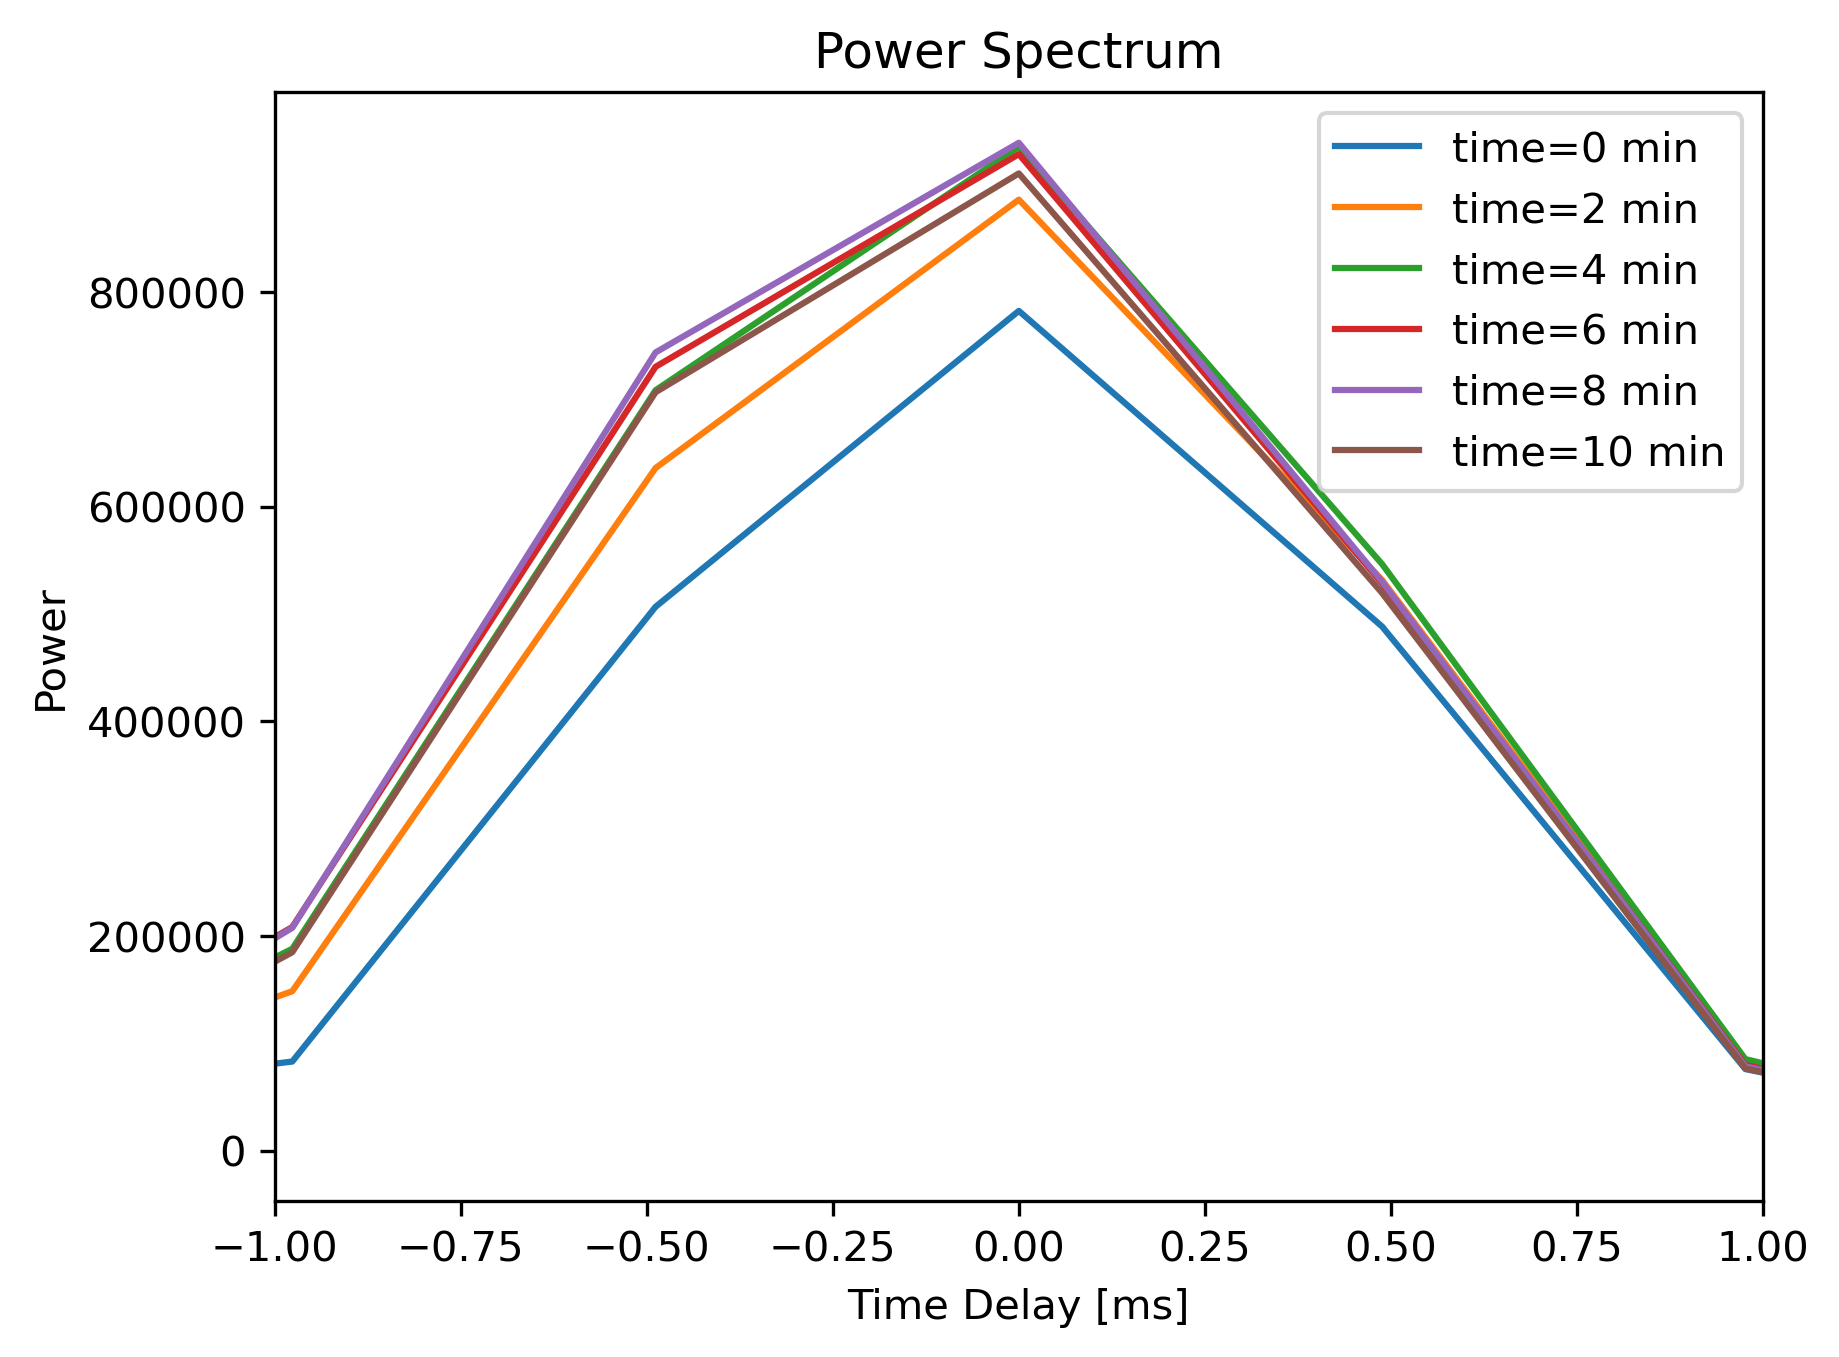

In [20]:
data_block_0 = data[0]
data_time_0 = data_block_0['time']

plt.figure(dpi=300)

t=0
for i in np.linspace(0, len(data)-1, 6).astype(int):
    data_block = data[i]
    corr = data_block['corr01']
    data_time = data_block['time']
    time = np.arange(len(corr)) * freq_to_period(freq/10**3) # in microseconds

    f = np.fft.fftshift(np.fft.fftfreq(1024, 1/freq))
    Fx = np.fft.fftshift(np.fft.fft(corr))
    pwr = np.abs(Fx)**2

    # plot one block of data (power)
    time_elapsed = int((data_time-data_time_0)/60)
    plt.plot(f/10**6, pwr, label=f'time={time_elapsed} min')
    t+=1

plt.legend()
plt.title('Power Spectrum')
plt.xlabel('Time Delay [ms]')
plt.ylabel('Power')
plt.xlim(-1, 1)
plt.show()

In [ ]:
# plot one channel of frequency to get power vs time, should be bessel function 
# plot it in 2d where x and y are time and frequency, z: power: 
    # should be able to see the fringes moving across, call np.angle around the sun